Processing: 01 - lol easy.jpg


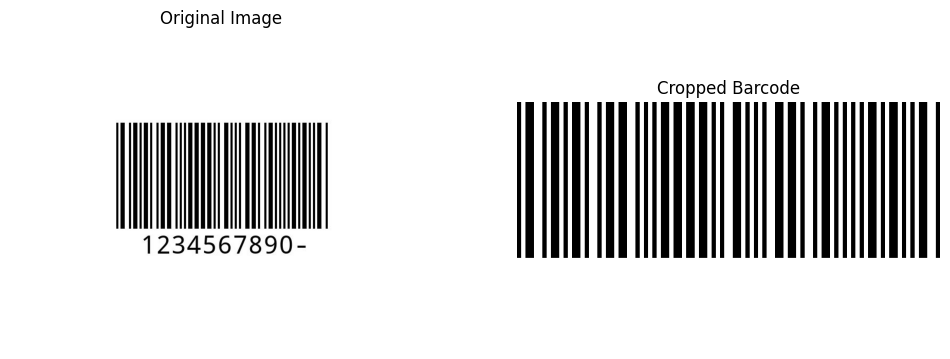

Processing: 02 - still easy.jpg


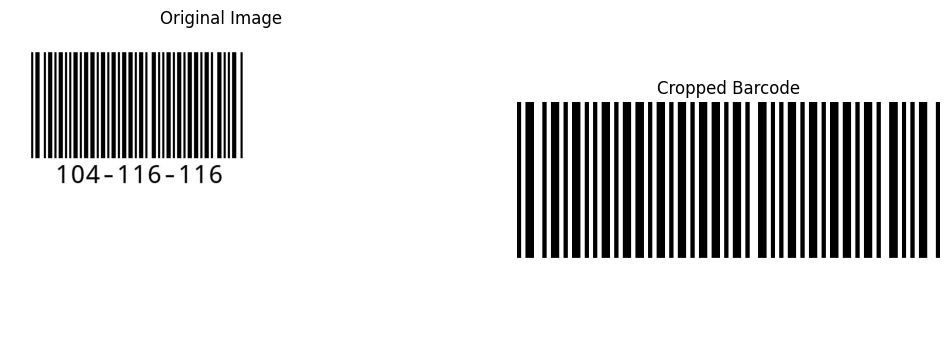

Processing: 03 - eda ya3am ew3a soba3ak mathazarsh.jpg


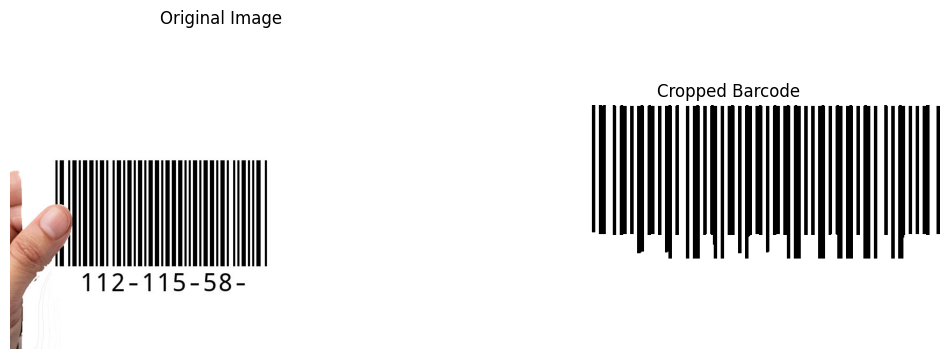

Processing: 04 - fen el nadara.jpg


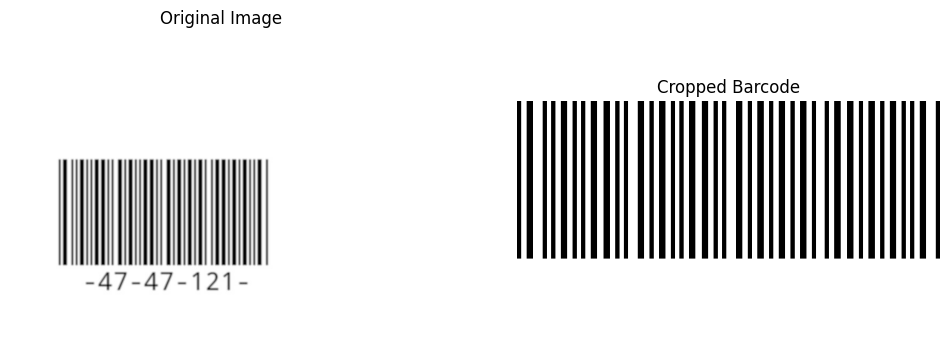

Processing: 05 - meen taffa el nour!!!.jpg


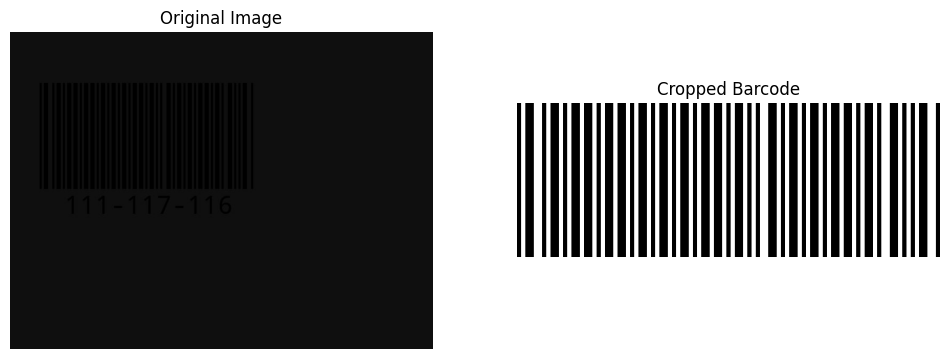

Processing: 06 - meen fata7 el nour 333eenaaayy.jpg


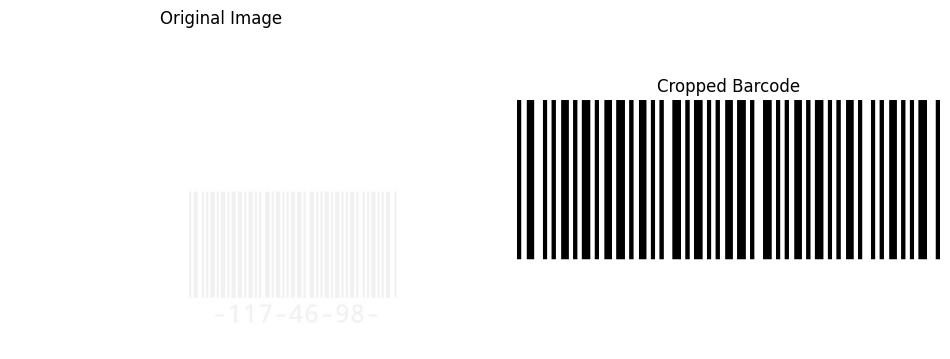

Processing: 07 - mal7 w felfel.jpg


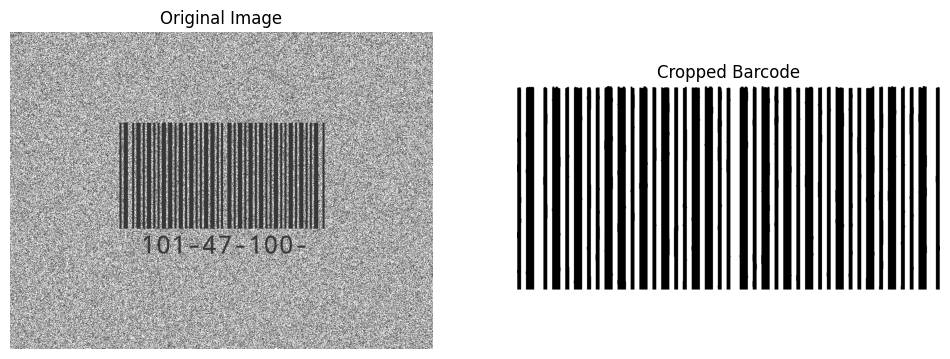

Processing: 08 - compresso espresso.jpg


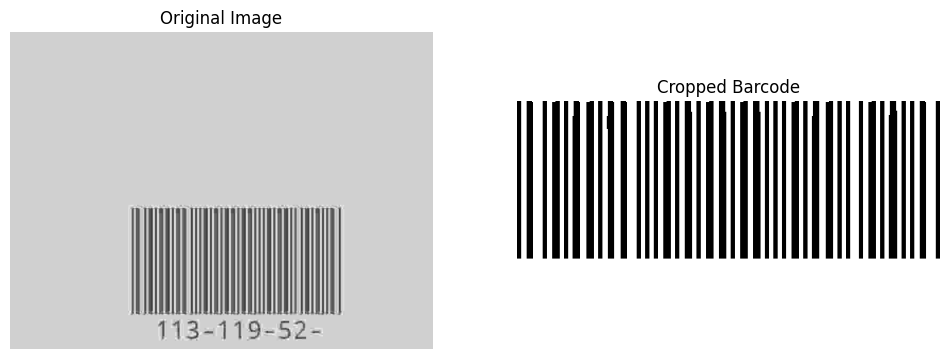

Processing: 09 - e3del el soora ya3ammm.jpg


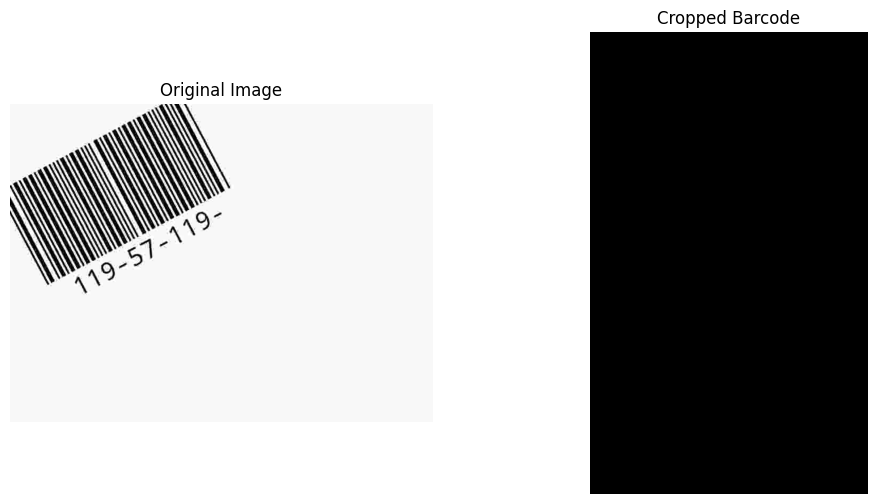

Processing: 10 - wen el kontraastttt.jpg


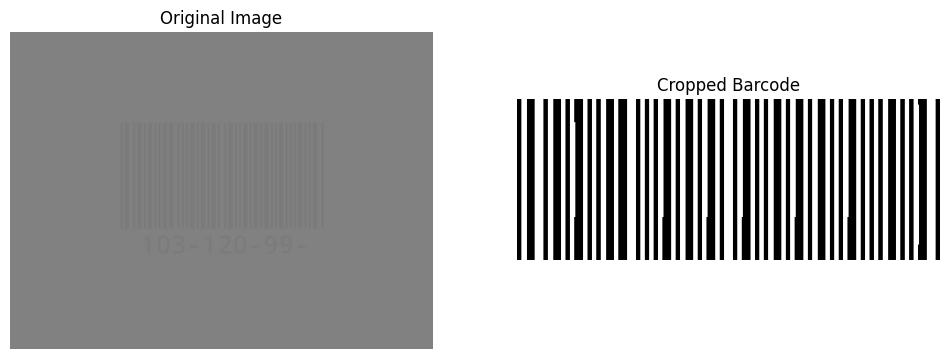

Processing: 11 - bayza 5ales di bsara7a.jpg
No contours detected! Skipping this image.


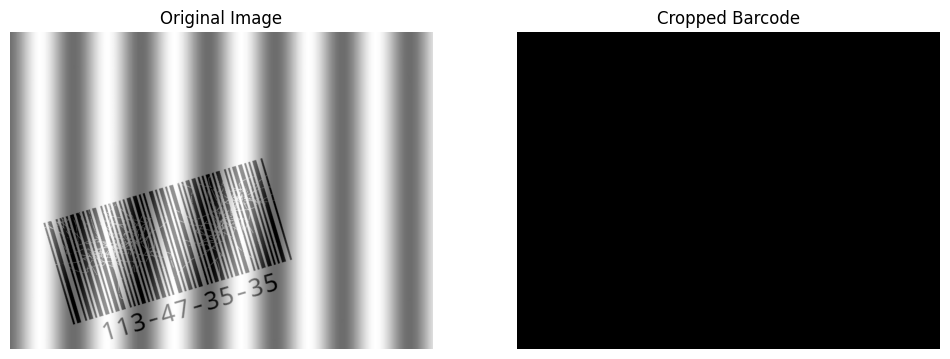

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import median_filter


def remove_numbers_from_bottom(img, margin=20):
    """
    Removes numbers or unwanted text at the bottom of the barcode by setting that area to white.
    """
    bottom_part = img[-margin:, :]
    _, thresholded_bottom = cv.threshold(bottom_part, 240, 255, cv.THRESH_BINARY_INV)
    img[-margin:, :] = cv.bitwise_or(img[-margin:, :], thresholded_bottom)
    img[-margin:, :] = 255
    return img

def crop_barcode(img):
    """
    Crops the barcode region from the image using contours.
    """
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    _, thresholded = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours detected! Skipping this image.")
        return img

    x_min = min([cv.boundingRect(contour)[0] for contour in contours])
    x_max = max([cv.boundingRect(contour)[0] + cv.boundingRect(contour)[2] for contour in contours])
    largest_contour = max(contours, key=cv.contourArea)
    _, y, _, h = cv.boundingRect(largest_contour)

    cropped_img = img[y:y + h, x_min:x_max]
    cropped_img = remove_numbers_from_bottom(cropped_img)

    return cropped_img
def display_before_after(original_img, cropped_img, title_before="Original Image", title_after="Cropped Barcode"):
    """
    Displays the before and after images side by side using Matplotlib.
    """
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 2, 1)
    if len(original_img.shape) == 2:  # Grayscale
        plt.imshow(original_img, cmap='gray')
    else:  # Color
        plt.imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
    plt.title(title_before)
    plt.axis('off')

    # Display the cropped barcode image
    plt.subplot(1, 2, 2)
    if len(cropped_img.shape) == 2:  # Grayscale
        plt.imshow(cropped_img, cmap='gray')
    else:  # Color
        plt.imshow(cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB))
    plt.title(title_after)
    plt.axis('off')

    plt.show()





def preprocess_image(image_path, special_image=False, straighten_and_clean=False, remove_hand_image=False):
    """
    Preprocesses the image based on specific conditions and adds vertical dilation to complete the barcode.
    
    Parameters:
        image_path (str): Path to the input image.
        special_image (bool): Flag to apply special preprocessing steps.
        straighten_and_clean (bool): Flag to apply straightening and cleaning.
        remove_hand_image (bool): Flag to remove the hand from the image.
    
    Returns:
        img (numpy.ndarray): The preprocessed image.
    """
    # Load the image in grayscale
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Unable to load image at path {image_path}")
        return None

    if remove_hand_image:
        img = remove_hand(image_path)
        if img is None:
            print(f"Error: Hand removal failed for image {image_path}")
            return None

  

    elif special_image:
        # Apply a vertical blur to smooth the image vertically
        kernel = np.ones((7, 1), np.float32) / 5
        img = cv.filter2D(img, -1, kernel)
        
        # Resize the image to increase barcode size
        scale_factor = 4
        img = cv.resize(img, (img.shape[1] * scale_factor, img.shape[0] * scale_factor))
        
        # Threshold the image to obtain a binary image
        _, img = cv.threshold(img, 128, 255, cv.THRESH_BINARY)
        
        # Apply morphological opening with a vertical structuring element
        kernel = np.zeros((13, 13), np.uint8)
        kernel[:, kernel.shape[1] // 2] = 1
        img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
        
        # Apply morphological closing with a larger vertical structuring element
        kernel = np.zeros((21, 21), np.uint8)
        kernel[:, kernel.shape[1] // 2] = 1
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
        
        # Apply another morphological closing with a horizontal structuring element
        kernel = np.ones((1, 5), np.uint8)
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
    
    else:
        # Apply Gaussian Blur to reduce noise
        img = cv.GaussianBlur(img, (5, 5), 0)
        
        # Normalize the image to enhance contrast
        img = cv.normalize(img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)
        
        # Apply Adaptive Thresholding to obtain a binary image
        img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 8)
        
        # Apply Morphological Closing with a horizontal structuring element
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 1))
        img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
        
        # Apply Morphological Opening with a vertical structuring element
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 3))
        img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
        
    # **Add Enhanced Vertical Dilation to Complete the Barcode**
    # Define a larger vertical structuring element for dilation
    vertical_dilation_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 12))  # Increased height from (1,8) to (1,15)
    
    # Apply dilation using the vertical structuring element with increased iterations
    img = cv.dilate(img, vertical_dilation_kernel, iterations=3)  # Increased iterations from 1 to 3
    
    # Optional: Apply morphological closing after dilation to smooth the barcode
    closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, closing_kernel, iterations=1)
    
    # Optional: Re-threshold to ensure binary image integrity
    _, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
    
    return img




def process_test_cases(image_folder, special_image_index, straighten_image_index, remove_hand_index):
    """
    Processes all images in the folder. Displays before and after images and saves only the cropped results.
    """
    files = [file_name for file_name in os.listdir(image_folder) if file_name.endswith(".jpg")]
    files.sort(key=lambda x: int(x.split(' ')[0]))
    output_folder = os.path.join(image_folder, "Processed_Output")
    os.makedirs(output_folder, exist_ok=True)

    for i, file_name in enumerate(files):
        print(f"Processing: {file_name}")
        image_path = os.path.join(image_folder, file_name)
        straighten_and_clean = (i + 1 == straighten_image_index)
        special_image = (i + 1 == special_image_index)
        remove_hand_image = (i + 1 == remove_hand_index)

        # Load original image
        original_img = cv.imread(image_path)
        cleaned_img = preprocess_image(image_path, special_image=special_image, straighten_and_clean=straighten_and_clean, remove_hand_image=remove_hand_image)
        cropped_img = crop_barcode(cleaned_img)

        # Save the cropped barcode image
        cropped_path = os.path.join(output_folder, f"Cropped_{file_name}")
        cv.imwrite(cropped_path, cropped_img)

        # Display before and after images
        display_before_after(original_img, cropped_img)
        
        
def remove_hand(image_path, debug=False):
 
    img = cv.imread(image_path)
    # Convert to HSV color space for better color segmentation
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Define a more comprehensive skin color range
    lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
    upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)

    lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
    upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)


    # Create two masks to cover the skin color range
    mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
    mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
    skin_mask = cv.bitwise_or(mask1, mask2)

    # Morphological operations to remove noise and close gaps
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_CLOSE, kernel, iterations=2)
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_OPEN, kernel, iterations=2)

    # Find contours in the skin mask
    contours, _ = cv.findContours(skin_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

 
    # Assume the largest contour is the hand
    largest_contour = max(contours, key=cv.contourArea)

    # Create a mask for the hand
    hand_mask = np.zeros_like(skin_mask)
    cv.drawContours(hand_mask, [largest_contour], -1, 255, thickness=cv.FILLED)


    # Invert the hand mask to prepare for inpainting
    hand_mask_inv = cv.bitwise_not(hand_mask)

    # Inpaint the original image using the inverted mask
    # You can choose between INPAINT_TELEA and INPAINT_NS methods
    img_no_hand = cv.inpaint(img, hand_mask, inpaintRadius=3, flags=cv.INPAINT_TELEA)
    
    # Step 5: Repair barcode------
    gray = cv.cvtColor(img_no_hand, cv.COLOR_BGR2GRAY)

    # Step 1: Threshold the grayscale image
    #_, binary = cv.threshold(gray, 150, 255, cv.THRESH_BINARY_INV)  # Lower threshold to 150
            # Step 1: Perform erosion to bridge gaps
    erosion_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 80))  # Tall vertical kernel
    binary_erode = cv.erode(gray, erosion_kernel, iterations=1)

    # Step 2: Perform dilate to clean small noise introduced by dilation
    dialation_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 80))  # Thin vertical kernel
    binary_opened = cv.dilate(binary_erode, dialation_kernel, iterations=1)
    dilationkernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 11))
    binary_final = cv.dilate(binary_opened, dilationkernel2, iterations=1)
    dilationkernel23 = cv.getStructuringElement(cv.MORPH_RECT, (1, 10))
    binary_finall = cv.dilate(binary_final, dilationkernel23, iterations=1)
    

    # # Step 4: Perform second dilation for line reinforcement
    # second_dilation_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 30))  # Smaller vertical dilation
    # binary_dilated_final = cv.dilate(binary_finall, second_dilation_kernel, iterations=1)
    # binary_erosion_final = cv.erode(binary_dilated_final, second_dilation_kernel, iterations=1)
    
    # # Step 5: Combine and invert back
    # repaired_barcode = cv.bitwise_not(cv.bitwise_xor(final_barcode,binary_finall))

    # Step 6: Combine repaired barcode with the original grayscale image
    #img_final = cv.bitwise_not(gray), binary_finall)
    kernel = np.ones((40, 1), np.float32) / 40
    vertical_mean_filtered = cv.filter2D(binary_finall, -1, kernel)
    final_barcode_no_hand = cv.normalize(vertical_mean_filtered, None, 0, 255, cv.NORM_MINMAX)


    return final_barcode_no_hand





if __name__ == "__main__":
    image_folder = "C:/Users/hp/Desktop/CV_Project/CV-main/Test Cases-20241123"
    special_image_index = 7
    straighten_image_index = 9
    remove_hand_index = 3
    process_test_cases(image_folder, special_image_index, straighten_image_index, remove_hand_index)